In [69]:
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms


from src import preprocess
from src import patient
from src import model
from src import metrics

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
data_dir = '/workdir/hassony/data'
train_dir = data_dir + '/Training'
save_dir = data_dir + '/storage'

train_df = pd.read_csv('/workdir/hassony/data/Training.csv')

In [107]:
patch_size = 30
patient_patches = preprocess.extract_all_patches(train_dir, patch_size)

In [108]:
print('{nb_patients} had at least one patch of size {patch_size}'.format(nb_patients=len(patient_patches), patch_size=patch_size))
nbs_patch = []
for patient_name in patient_patches:
    nbs_patch.append(len(patient_patches[patient_name]))
    
print('{nb_patch} patches were extracted in total'.format(nb_patch=np.sum(nbs_patch)))

97 had at least one patch of size 30
441991 patches were extracted in total


In [109]:
train_df

,Patient_ID,HPV/p16_status,Gender,Age_at_diagnosis,Race,Tumor_side,Tumor_subsite,T_category,N_category,AJCC_Stage,Pathological_grade,Smoking_status_at_diagnosis,Smoking_Pack-Years
0,1,1,Male,58,White,L,Tonsil,2,0,II,III,Former,5.0
1,2,0,Female,78,White,R,BOT,3,0,III,II,Former,70.0
2,3,1,Male,57,White,R,Tonsil,1,2b,IV,III,Current,30.0
3,4,1,Female,56,White,R,BOT,2,2b,IV,III,Never,0.0
4,5,1,Female,60,White,L,Tonsil,2,2b,IV,II,Never,0.0
5,6,1,Male,66,White,R,BOT,1,1,III,III,Never,0.0
6,7,1,Female,72,White,L,BOT,4,0,IV,II,Former,26.0
7,9,0,Female,71,White,L,Tonsil,1,2a,IV,I,Former,50.0
8,11,1,Male,50,White,L,BOT,3,2b,IV,III,Current,30.0
9,12,1,Male,54,White,R,BOT,2,2c,IV,II,Former,60.0


In [110]:
pkl.dump(patient_patches, open(save_dir +
                                '/train_patient_patches_size{size}.pkl'.format(size=patch_size),
                                'wb'))
patient_patches = pkl.load( open(save_dir + '/train_patient_patches_size{size}.pkl'.format(size=patch_size), 'rb'))

In [111]:
# Get hpv-positive and hpv-negative patients
pos_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 1)
neg_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 0)
print('{0} negative hpv patients'.format(len(neg_patients)))
print('{0} positive hpv patients'.format(len(pos_patients)))

15 negative hpv patients
35 positive hpv patients


In [112]:
# Create a train-test-split with same number of negative and positive hpv patients in each set

# Insure test-train split is consistent
np.random.seed(2)
    
train_list, test_list = model.make_train_test_lists(pos_patients, neg_patients)
print('train patients : {0}'.format(train_list))
print('test patients : {0}'.format(test_list))

train patients : [49, 51, 111, 44, 121, 139, 1, 78, 48, 12, 64, 136, 107, 99, 46, 30, 38, 24, 273, 174, 143, 285, 2, 313]
test patients : [26, 116, 37, 79, 153, 82, 122, 70, 23, 39, 150, 137, 71, 47, 84, 43, 54, 57, 312, 13, 196, 15, 194, 22]


In [113]:
# Extract patches and targets as list of tensors and list of int respectively
train_patches, train_targets = model.create_patch_target(train_list, patient_patches, train_df)
test_patches, test_targets = model.create_patch_target(test_list, patient_patches, train_df)


In [114]:
print('Extracted {patch_nb} patches for training'.format(patch_nb=len(train_patches)))
print('Extracted {patch_nb} patches for testing'.format(patch_nb=len(test_patches)))

Extracted 191511 patches for training
Extracted 249405 patches for testing


In [115]:
mean_patch = model.get_mean_patch(train_patches)

In [116]:
np.mean(mean_patch.numpy())
np.max(mean_patch.numpy())

1097.5607

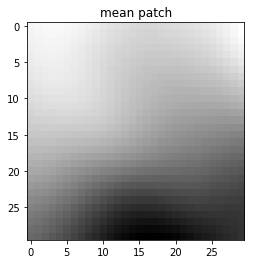

In [117]:
mean_patch
plt.imshow(mean_patch.numpy(), cmap='gray')
plt.title('mean patch')
plt.show()


In [118]:
train_target_tensors, train_patch_tensors = model.create_balanced_tensors(train_targets, train_patches, disp=True)
test_target_tensors, test_patch_tensors = model.create_balanced_tensors(test_targets, test_patches, disp=True)


87573 positive patches
103938 negative patches
133163 positive patches
116242 negative patches


In [119]:
print(train_patch_tensors.size())
print(test_patch_tensors.size())

torch.Size([175146, 1, 30, 30])
torch.Size([232484, 1, 30, 30])


In [120]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(train_patch_tensors, train_target_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(test_patch_tensors, test_target_tensors)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
print(len(train_loader), 'training samples')
print(len(test_loader), 'training samples')

17515 training samples
23249 training samples


In [121]:
class Convnet(nn.Module):
    """
    takes patches of size 25 as input
    """
    def __init__(self, patch_size):
        self.size_before_fc = self.get_size_after_conv(patch_size)
        super(Convnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*(self.size_before_fc**2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x , 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 64*(self.size_before_fc**2))
        x = F.relu(self.fc1(x))  
        x = F.softmax(self.fc2(x))
        return x

    def get_size_after_conv(self, initial_size):
        final_size = initial_size
        # first conv bloc
        final_size = (final_size - 2)//2
        # second conv bloc
        final_size = (final_size - 2)//2
        # third conv bloc
        final_size = (final_size - 2)//2
        return final_size

In [122]:
def train_net(dataloader, net, loss_criterion, mean_patch, optimizer, learn=True):
    running_loss = 0.0
    prediction = []
    target = []
    for i, data_item in enumerate(dataloader, 0):
        if (i<400):
            # get the inputs
            inputs, labels = data_item

            # Remove mean patch from current patch
            inputs = inputs - mean_patch.repeat(inputs.size()[0], 1, 1, 1)
            labels = labels.squeeze()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            for label in labels:
                if(label.data[0]==1):
                    target.append(1)
                else:
                    target.append(0)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
            loss = loss_criterion(outputs, labels)

            # if learning  backward + optimize
            if (learn):
                loss.backward()        
                optimizer.step()

            running_loss += loss.data[0]
            
            
            for output in outputs:
                if(output.data[0]>0.5):
                    prediction.append(1)
                else:
                    prediction.append(0)
            
            # If network currently learning

    return prediction, target, running_loss


In [123]:
def simulation(dataloader, test_dataloader, net, loss_criterion, mean_patch, epochNb, learning_rate):
    
    # Initialize performance arrays
    train_losses = np.zeros(epochNb)
    train_accuracies = np.zeros(epochNb)
    test_losses = np.zeros(epochNb)
    test_accuracies = np.zeros(epochNb)

    train_learning = False
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochNb): # loop over the dataset multiple times
        if (epoch>0):
            train_learning = True

        # train
        prediction, target, train_loss = train_net(dataloader, net, loss_criterion, mean_patch,
                                                   optimizer, learn=train_learning)
        train_conf_mat, train_acc = metrics.get_metrics(target, prediction)
        train_losses[epoch] = train_loss

        # Save results
        train_accuracies[epoch] = train_acc
        train_losses[epoch] = train_loss
        
        # print epoch train results
        print('Training loss: {los}'.format(los=train_loss))
        print('Training confusion matrix')
        print(train_conf_mat)
        print('Training accuracy : ', train_acc) 

        # test
        test_prediction, test_target, test_loss = train_net(test_dataloader, net, loss_criterion, mean_patch,
                                                            optimizer, learn=False)
        test_conf_mat, test_acc = metrics.get_metrics(test_target, test_prediction)
        test_losses[epoch] = test_loss

        # Save results
        test_accuracies[epoch] = test_acc
        test_losses[epoch] = test_loss
        
        # print epoch train results
        print('Testing loss: {los}'.format(los=test_loss))
        print('Testing confusion matrix')
        print(test_conf_mat)
        print('Testing accuracy : ', test_acc) 
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [127]:
torch.manual_seed(2)
net_model = Convnet(patch_size)

bce_criterion = nn.BCELoss()
epoch = 10
learning_rate = 0.0001
momentum = 0.9
train_losses, test_losses, train_accuracies, test_accuracies = simulation( test_loader, train_loader, net_model, bce_criterion, mean_patch, epoch, learning_rate)

Training loss: 593.364743411541
Training confusion matrix
[[  922.   735.]
 [ 1050.  1293.]]
Training accuracy :  0.55375
Testing loss: 1249.4741496443748
Testing confusion matrix
[[  702.   667.]
 [ 1261.  1370.]]
Testing accuracy :  0.518
Training loss: 302.57427367568016
Training confusion matrix
[[ 1269.   863.]
 [  756.  1112.]]
Training accuracy :  0.59525
Testing loss: 465.02394130825996
Testing confusion matrix
[[ 1158.   735.]
 [  850.  1257.]]
Testing accuracy :  0.60375
Training loss: 233.98964735865593
Training confusion matrix
[[ 1286.   549.]
 [  708.  1457.]]
Training accuracy :  0.68575
Testing loss: 385.624657779932
Testing confusion matrix
[[ 1487.  1094.]
 [  503.   916.]]
Testing accuracy :  0.60075
Training loss: 218.07065358757973
Training confusion matrix
[[ 1468.   544.]
 [  566.  1422.]]
Training accuracy :  0.7225
Testing loss: 328.92539516091347
Testing confusion matrix
[[ 1401.   897.]
 [  671.  1031.]]
Testing accuracy :  0.608
Training loss: 201.3757357597

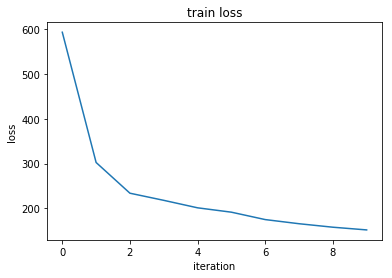

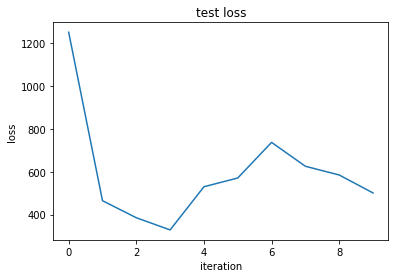

In [128]:
plt.plot(train_losses)
plt.title('train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(test_losses)
plt.title('test loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

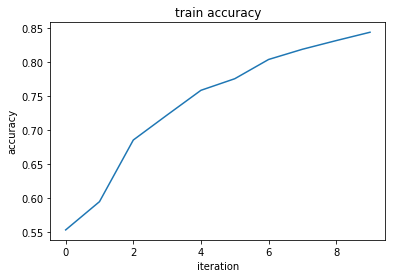

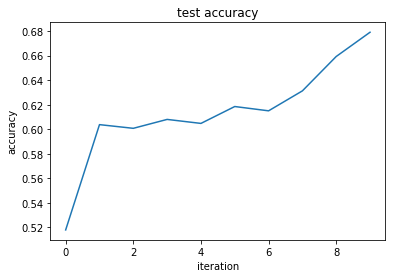

In [129]:
plt.plot(train_accuracies)
plt.title('train accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()
plt.plot(test_accuracies)
plt.title('test accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
prediction_, target_, loss_ = train_net(test_loader, model, bce_criterion, mean_patch,  optimizer, learn=False)
metrics.get_metrics(target_, prediction_)

In [44]:
test_accuracies

array([ 0.399  ,  0.54075,  0.50925,  0.55225,  0.52725,  0.5405 ,
        0.57375,  0.57175,  0.58375,  0.59025])